# Regression using Deep Neural Networks

## Load Dataset from sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

/Users/moonseokmin/miniforge3/envs/krc/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Calif

In [6]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['TARGET'] = boston.target
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [9]:
scaler = StandardScaler()
df.values[:, :-1] = scaler.fit_transform(df.values[:, :-1])

df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
501,-0.413229,-0.487722,0.115738,-0.272599,0.158124,0.439316,0.018673,-0.625796,-0.982843,-0.803212,1.176466,0.387217,-0.418147,22.4
502,-0.415249,-0.487722,0.115738,-0.272599,0.158124,-0.234548,0.288933,-0.716639,-0.982843,-0.803212,1.176466,0.441052,-0.500850,20.6
503,-0.413447,-0.487722,0.115738,-0.272599,0.158124,0.984960,0.797449,-0.773684,-0.982843,-0.803212,1.176466,0.441052,-0.983048,23.9
504,-0.407764,-0.487722,0.115738,-0.272599,0.158124,0.725672,0.736996,-0.668437,-0.982843,-0.803212,1.176466,0.403225,-0.865302,22.0
505,-0.415000,-0.487722,0.115738,-0.272599,0.158124,-0.362767,0.434732,-0.613246,-0.982843,-0.803212,1.176466,0.441052,-0.669058,11.9


---
## Train Model with PyTorch

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
data = torch.from_numpy(df.values).float()

data.shape

torch.Size([506, 14])

In [12]:
## Split x, y

x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.size())

torch.Size([506, 13]) torch.Size([506, 1])


In [13]:
## Define configuration

n_epochs = 100000
learning_rate = 1e-4
print_interval = 5000

---
## Build Models

### Build Model using nn.Module

In [14]:
## Activation function
relu = nn.ReLU()
leaky_relu = nn.LeakyReLU(negative_slope=0.1)

In [15]:
class MyModel(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        super().__init__()
        
        self.linear1 = nn.Linear(input_dim, 8)
        self.linear2 = nn.Linear(8, 4)
        self.linear3 = nn.Linear(4, 2)
        self.linear4 = nn.Linear(2, output_dim)
        self.act = nn.ReLU()
        
    def forward(self, x):
        # |x| = (batch_size, input_dim) ## tensor
        h = self.act(self.linear1(x))
        h = self.act(self.linear2(h))
        h = self.act(self.linear3(h))
        y = self.linear4(h)
        # |y| = (batch_size, output_dim)
        
        return y

In [16]:
model_module = MyModel(x.size(-1), y.size(-1))
model_module

MyModel(
  (linear1): Linear(in_features=13, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (linear3): Linear(in_features=4, out_features=2, bias=True)
  (linear4): Linear(in_features=2, out_features=1, bias=True)
  (act): ReLU()
)

In [18]:
optimizer_module = optim.SGD(model_module.parameters(),
                      lr=learning_rate)
mse_loss = nn.MSELoss()

In [20]:
for i in range(n_epochs):
    y_hat = model_module(x)
    loss = mse_loss(y_hat, y)
    
    optimizer_module.zero_grad()
    loss.backward()
    
    optimizer_module.step()
    
    if (i + 1) % print_interval == 0:
        print(f"Epoch {i + 1}: loss={loss:.4f}")

Epoch 5000: loss=11.1425
Epoch 10000: loss=8.9884
Epoch 15000: loss=7.9888
Epoch 20000: loss=7.5127
Epoch 25000: loss=7.0681
Epoch 30000: loss=6.6909
Epoch 35000: loss=6.3235
Epoch 40000: loss=6.0672
Epoch 45000: loss=5.8494
Epoch 50000: loss=5.6366
Epoch 55000: loss=5.4809
Epoch 60000: loss=5.4060
Epoch 65000: loss=5.3669
Epoch 70000: loss=5.3408
Epoch 75000: loss=5.3233
Epoch 80000: loss=5.3067
Epoch 85000: loss=5.2891
Epoch 90000: loss=5.2703
Epoch 95000: loss=5.2289
Epoch 100000: loss=5.1548


---
## Build Model with LeakyReLU using nn.Sequential

In [26]:
model_sequential = nn.Sequential(
    nn.Linear(x.size(-1), 16),
    nn.LeakyReLU(),
    nn.Linear(16, 8),
    nn.LeakyReLU(),
    nn.Linear(8, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 2),
    nn.LeakyReLU(),
    nn.Linear(2, y.size(-1)),
)

model_sequential

Sequential(
  (0): Linear(in_features=13, out_features=16, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=16, out_features=8, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=8, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=2, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=2, out_features=1, bias=True)
)

In [27]:
optimizer_sequential = optim.SGD(model_sequential.parameters(),
                                 lr=learning_rate)

In [28]:
for i in range(n_epochs):
    y_hat = model_sequential(x)
    loss = mse_loss(y_hat, y)
    
    optimizer_sequential.zero_grad()
    loss.backward()
    
    optimizer_sequential.step()
    
    if (i + 1) % print_interval == 0:
        print(f"Epoch {i + 1}: loss={loss:.4f}")

Epoch 5000: loss=152.9161
Epoch 10000: loss=93.6859
Epoch 15000: loss=85.6731
Epoch 20000: loss=84.5891
Epoch 25000: loss=84.4424
Epoch 30000: loss=84.4225
Epoch 35000: loss=84.4197
Epoch 40000: loss=84.4192
Epoch 45000: loss=84.4190
Epoch 50000: loss=84.4188
Epoch 55000: loss=84.4187
Epoch 60000: loss=84.4185
Epoch 65000: loss=84.4183
Epoch 70000: loss=84.4181
Epoch 75000: loss=84.4179
Epoch 80000: loss=84.4177
Epoch 85000: loss=84.4175
Epoch 90000: loss=84.4173
Epoch 95000: loss=84.4170
Epoch 100000: loss=84.4167


---
## Result

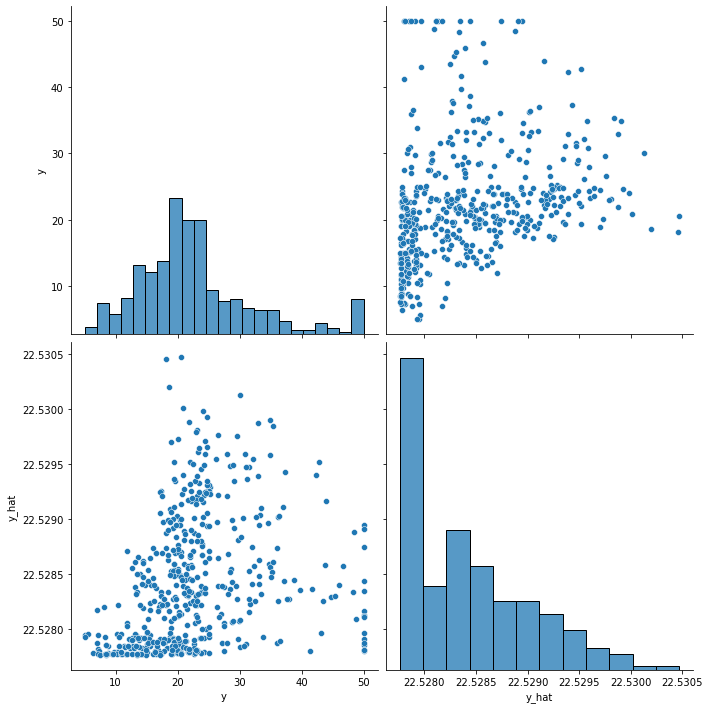

In [30]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(),
                  columns=['y', 'y_hat'])

sns.pairplot(df, height=5)
plt.show()